## 一 环境配置

In [1]:
# gpu
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 二 数据准备

In [2]:
# 参数配置
train_parameters = {
    "input_size": [3, 224, 224],                     # 输入图片的shape
    "class_dim": 25,                                 # 分类数
    "src_path": "data/data55032/archive_train.zip",   # 原始数据集路径
    "target_path": "./data/dataset",     # 要解压的路径
    "train_list_path": "./train.txt",                # train_data.txt路径
    "eval_list_path": "./eval.txt",                  # eval_data.txt路径
    "label_dict": {},                                 # 标签字典
    "readme_path": "./data/readme.json",
    "num_epochs": 10,                                # 训练轮数
    "train_batch_size": 32,                          # 批次的大小
    "learning_strategy": {                           # 优化函数相关的配置
        "lr": 0.0005                                 # 超参数学习率
    }
}


In [3]:
def unzip_data(src_path, target_path):
    #解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    if not os.path.isdir(target_path):    
        with zipfile.ZipFile(src_path, 'r') as z:
            z.extractall(path=target_path)
        print("解压完成")
    else:
        print("文件已解压")

In [4]:
def get_data_list(target_path, train_list_path, eval_list_path):
    '''
    生成数据列表
    '''
    # 获取所有类别保存的文件夹名称
    data_list_path = target_path
    class_dirs = os.listdir(data_list_path) 
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # 存储要写进eval.txt和train.txt中的内容
    trainer_list = []
    eval_list = []
    class_label = 0
    i = 0
    
    for class_dir in class_dirs:   
        path = os.path.join(data_list_path, class_dir)
        # 获取所有图片
        img_paths = os.listdir(path)
        for img_path in img_paths:                                        # 遍历文件夹下的每个图片
            i += 1
            name_path = os.path.join(path, img_path)                       # 每张图片的路径
            if i % 10 == 0:                                               
                eval_list.append(name_path + "\t%d" % class_label + "\n")
            else: 
                trainer_list.append(name_path + "\t%d" % class_label + "\n") 
        
        train_parameters['label_dict'][str(class_label)] = class_dir
        class_label += 1
            
    # 乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    # 乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 
 
    print('生成数据列表完成！')

In [5]:
# 参数初始化
src_path = train_parameters['src_path']
target_path = train_parameters['target_path']
train_list_path = train_parameters['train_list_path']
eval_list_path = train_parameters['eval_list_path']
batch_size = train_parameters['train_batch_size']

# 解压原始数据到指定路径
unzip_data(src_path, target_path)

# 每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
# 生成数据列表   
get_data_list(target_path, train_list_path, eval_list_path)

文件已解压
生成数据列表完成！


In [6]:
class GemstoneDataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []
        
        if mode == 'train':
            list_path = os.path.join(self.data_path, "train.txt")
        else:
            list_path = os.path.join(self.data_path, "eval.txt")
            
        with open(list_path, "r", encoding="utf-8") as f:
            self.info = f.readlines()
            
        for img_info in self.info:
            img_path, label = img_info.strip().split('\t')
            self.img_paths.append(img_path)
            self.labels.append(int(label))
            
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        img = self.transform(img)
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)


In [7]:
# 训练数据加载
train_dataset = GemstoneDataset('.', mode='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 测试数据加载
eval_dataset = GemstoneDataset('.', mode='eval')
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

# 测试数据集
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)


文件名 ./data/dataset\Pearl\pearl_36.jpg 	标签值 18
730
文件名 ./data/dataset\Malachite\malachite_12.jpg 	标签值 16
81
torch.Size([3, 224, 224])
torch.Size([])


## 三 模型结构

In [8]:
# 可视化函数
Batch = 0
Batchs = []
all_train_accs = []

def draw_train_acc(Batchs, train_accs):
    title = "training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss = []
def draw_train_loss(Batchs, train_loss):
    title = "training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # 卷积层1：输入通道3 -> 输出64，无padding卷积: 224->222，经2×2池化 -> 111
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=0),  # 224->222
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 222/2=111
        )
        # 卷积层2：64 -> 128, kernel=4, 无padding: 111->108，经2×2池化 -> 54
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, padding=0),  # 111->108
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 108/2=54
        )
        # 卷积层3：128 -> 50, kernel=5, 无padding卷积: 54->50，经2×2池化 -> 25
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 50, kernel_size=5, padding=0),  # 54->50
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 50/2=25
        )
        # 展平后的特征维度：50 * 25 * 25 = 31250
        self.flatten_dim = 50 * 25 * 25
        # 全连接层：输出类别数为25
        self.fc = nn.Linear(self.flatten_dim, train_parameters["class_dim"])
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

## 四 模型训练

epoch:0, step:5, train_loss:3.0662, train_acc:0.1875
epoch:0, step:10, train_loss:2.9153, train_acc:0.1875
epoch:0, step:15, train_loss:2.5230, train_acc:0.3125
epoch:0, step:20, train_loss:2.5258, train_acc:0.2500
epoch:0, step:25, train_loss:2.4810, train_acc:0.1875
epoch:0, step:30, train_loss:1.9195, train_acc:0.3750
epoch:0, step:35, train_loss:1.7141, train_acc:0.6250
epoch:0, step:40, train_loss:1.9560, train_acc:0.5000
epoch:0, step:45, train_loss:1.5609, train_acc:0.8000
epoch:1, step:5, train_loss:1.3046, train_acc:0.6250
epoch:1, step:10, train_loss:1.0294, train_acc:0.8125
epoch:1, step:15, train_loss:1.3539, train_acc:0.5625
epoch:1, step:20, train_loss:1.3855, train_acc:0.6250
epoch:1, step:25, train_loss:1.0550, train_acc:0.7500
epoch:1, step:30, train_loss:1.3004, train_acc:0.5625
epoch:1, step:35, train_loss:1.0712, train_acc:0.8125
epoch:1, step:40, train_loss:1.0736, train_acc:0.8125
epoch:1, step:45, train_loss:1.6800, train_acc:0.6000
epoch:2, step:5, train_loss:1.

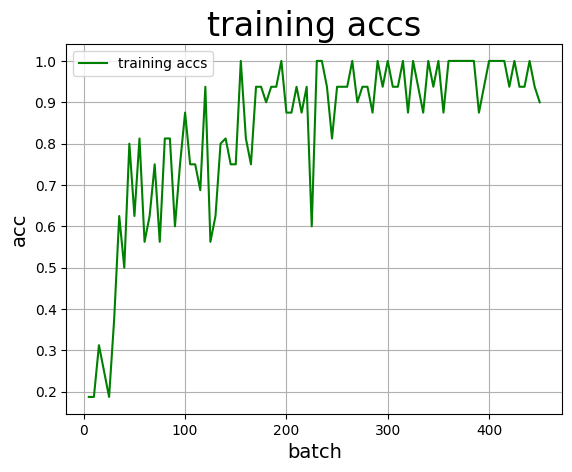

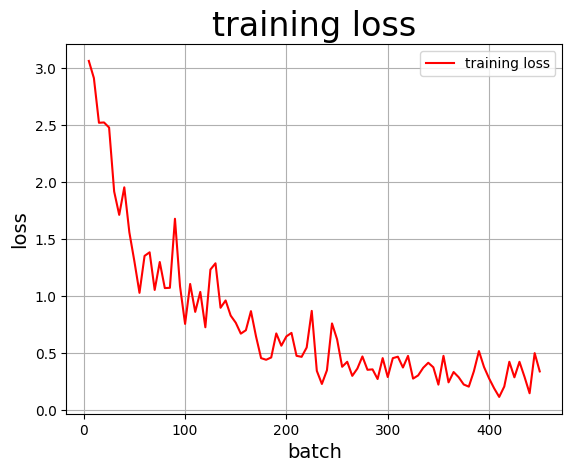

In [10]:
# 四 模型训练

model = MyCNN().to(device)  # 模型实例化
model.train()  # 训练模式
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=train_parameters['learning_strategy']['lr'])

epochs_num = train_parameters['num_epochs']  # 迭代次数

for epoch in range(epochs_num):
    for batch_idx, (data, target) in enumerate(train_loader):
        # 将数据搬运到 GPU
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # 前向传播
        pred = model(data)
        # 计算交叉熵损失
        loss = criterion(pred, target)
        # 计算精度
        _, predicted = torch.max(pred, 1)
        acc = (predicted == target).float().mean()
        # 反向传播
        loss.backward()
        optimizer.step()
        
        if batch_idx != 0 and batch_idx % 5 == 0:
            Batch = Batch + 5
            Batchs.append(Batch)
            all_train_loss.append(loss.item())
            all_train_accs.append(acc.item())
            print(f"epoch:{epoch}, step:{batch_idx}, train_loss:{loss.item():.4f}, train_acc:{acc.item():.4f}")


# 保存模型
torch.save(model.state_dict(), 'MyCNN.pth')

# 绘制训练曲线
draw_train_acc(Batchs, all_train_accs)
draw_train_loss(Batchs, all_train_loss)

## 五 模型评估

**多运行几次**取的一个好结果

In [11]:
# 加载模型
model = MyCNN()
model.load_state_dict(torch.load('MyCNN.pth'))
model.eval()  # 验证模式

accs = []

with torch.no_grad():
    for data, target in eval_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        acc = correct / len(data)
        accs.append(acc)

avg_acc = np.mean(accs)
print("当前模型在测试集上的准确率为:", avg_acc)

当前模型在测试集上的准确率为: 0.8181818181818182


## 六 模型预测

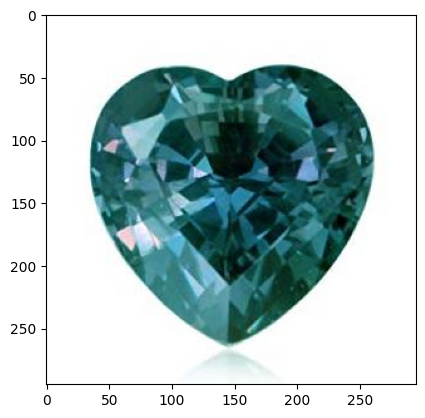

样本被预测为：Alexandrite, 真实标签为：alexandrite
结束


In [12]:
def unzip_infer_data(src_path, target_path):
    '''
    解压预测数据集
    '''
    if not os.path.isdir(target_path):     
        with zipfile.ZipFile(src_path, 'r') as z:
            z.extractall(path=target_path)
        print("解压完成")

def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    img = transform(img)
    return img

infer_src_path = './data/data55032/archive_test.zip'
infer_dst_path = './data/archive_test'
unzip_infer_data(infer_src_path, infer_dst_path)

# 加载模型
model = MyCNN()
model.load_state_dict(torch.load('MyCNN.pth'))
model.eval()

# 展示预测图片
infer_path = 'data/archive_test/alexandrite_3.jpg'
img = Image.open(infer_path)
plt.imshow(img)
plt.show()

# 对预测图片进行预处理
img_tensor = load_image(infer_path)
img_tensor = img_tensor.unsqueeze(0)  # 增加batch维度

# 预测
with torch.no_grad():
    output = model(img_tensor)
    pred = output.argmax(dim=1).item()

label_dic = train_parameters['label_dict']
if str(pred) in label_dic:
    print(f"样本被预测为：{label_dic[str(pred)]}, 真实标签为：{infer_path.split('/')[-1].split('_')[0]}")
else:
    print(f"预测标签 {str(pred)} 不在 label_dic 中")

print("结束")